Necessary imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re  # For parsing chemical formulas

Define your training dataset

In [3]:
data = {
    "Composition": ["Al2O3", "SiO2", "MgO", "CaO", "Al2SiO5", "ZnO", "CuO", "Fe2O3", "K2O", "TiO2"],
    "Thermal Expansion Coefficient": [8.0, 0.5, 13.0, 12.0, 4.5, 10.0, 8.5, 9.0, 15.0, 7.5]
}
df = pd.DataFrame(data)  # Create a pandas DataFrame for the dataset

Compositions can't be used directly as input to VAE so this step conversts them into fractional elemental composition (maybe not the best way to do it)

In [ ]:
elements_set = set()
for comp in df["Composition"]:
    matches = re.findall(r"[A-Z][a-z]*", comp)  # Match element symbols (e.g., Al, Si)
    elements_set.update(matches)
elements =  sorted(elements_set)

def encode_composition(comp):
    """
    Encodes a chemical composition as fractions of each element.
    :param comp: The chemical formula (e.g., "Al2O3")
    :return: A list of fractional contributions for each element in 'elements'
    """
    # Initialize the encoding for all elements with zero
    encoding = {el: 0 for el in elements}
    # Parse the composition into elements and their counts
    matches = re.findall(r"([A-Z][a-z]*)(\d*)", comp)
    for el, count in matches:
        count = int(count) if count else 1  # Default count is 1 if not specified
        encoding[el] += count  # Add the count to the corresponding element
    # Normalize the counts to fractions
    total_atoms = sum(encoding.values())
    return [encoding[el] / total_atoms for el in elements]

# Encode the compositions
compositions_encoded = np.array([encode_composition(c) for c in df["Composition"]])

# Prepare the thermal expansion coefficients as input
thermal_exp_coefficients = df["Thermal Expansion Coefficient"].values.reshape(-1, 1)

# Print the encoded dataset
print("Encoded Compositions (Fractional):")
print(compositions_encoded[:10])

Encoded Compositions (Fractional):
[[0.4        0.         0.         0.         0.         0.
  0.6        0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.         0.         0.         0.5
  0.5        0.         0.         0.        ]
 [0.         0.5        0.         0.         0.         0.
  0.5        0.         0.         0.        ]
 [0.25       0.         0.         0.         0.         0.
  0.625      0.125      0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.5        0.         0.         0.5       ]
 [0.         0.         0.5        0.         0.         0.
  0.5        0.         0.         0.        ]
 [0.         0.         0.         0.4        0.         0.
  0.6        0.         0.         0.        ]
 [0.         0.         0.         0.         0.66666667 0.
  0.33333333 0.         0.         0.        ]
 

Define CVAE parameters and build the model

In [16]:
# Define CVAE parameters
latent_dim = 2  # Dimension of the latent space
hidden_dims = [64, 32, 30]  # Hidden layers in the encoder and decoder
batch_size = 4  # Batch size for training
epochs = 30  # Number of epochs
learning_rate = 0.001  # Learning rate for the optimizer

# Encoder Model
def build_encoder(input_dim, property_dim, hidden_dims, latent_dim):
    """
    Builds the encoder that maps compositions (input data) and properties (e.g., thermal expansion coefficients)
    into a compressed latent space representation (z_mean, z_log_var, and z).
    
    Parameters:
    - input_dim: Number of features in the encoded composition input (e.g., number of elements).
    - property_dim: Number of features for the additional property input (e.g., scalar value for thermal expansion coefficient).
    - hidden_dims: List specifying the number of units in each hidden layer (e.g., [64, 32]).
    - latent_dim: Size of the latent space vector (dimensionality of z).
    
    Returns:
    - A Keras Model that takes composition and property as inputs and outputs z_mean, z_log_var, and z.
    """

    # Step 1: Define the input for compositions
    input_data = Input(shape=(input_dim,), name="composition_input")  
    # input_data represents the encoded composition as a vector of size input_dim.
    # Example: If the composition is represented as 10 fractional values, input_dim = 10.

    # Step 2: Define the input for properties
    input_property = Input(shape=(property_dim,), name="property_input")  
    # input_property represents the thermal expansion coefficient (or other properties).
    # Example: property_dim = 1 for a single scalar value (e.g., thermal expansion coefficient).

    # Step 3: Concatenate the inputs
    x = Concatenate(name="concatenate_inputs")([input_data, input_property])  
    # Why concatenate?
    # - The CVAE conditions the generation process on the property.
    # - Concatenation combines the composition and property into a single vector.
    # - This ensures the network can jointly learn the relationship between the composition and the property.
    # Example: If input_data has shape (10,) and input_property has shape (1,), x will have shape (11,).

    # Step 4: Add hidden layers for encoding
    for dim in hidden_dims:  
        # Iterate through each specified hidden layer size in hidden_dims (e.g., [64, 32]).
        x = Dense(dim, activation='relu', name=f"hidden_{dim}")(x)  
        # Dense layer with ReLU activation introduces non-linearity to capture complex patterns.
        # x progressively becomes a higher-level representation of the inputs.

    # Step 5: Output the mean of the latent space distribution
    z_mean = Dense(latent_dim, name="z_mean")(x)  
    # z_mean is the center (mean) of the learned latent space distribution for each input.
    # It helps in capturing the most likely latent representation of the inputs.

    # Step 6: Output the log variance of the latent space distribution
    z_log_var = Dense(latent_dim, name="z_log_var")(x)  
    # z_log_var represents the log of the variance of the learned latent space distribution.
    # Using log variance improves numerical stability during training.

    # Step 7: Sampling Layer (Reparameterization Trick)
    def sampling(args):
        z_mean, z_log_var = args  # The function takes z_mean and z_log_var as input.
        epsilon = tf.random.normal(shape=tf.shape(z_mean))  # Random noise sampled from a standard normal distribution.
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon  
        # Reparameterization trick:
        # - Allows stochastic sampling while still enabling gradient backpropagation.
        # - Combines z_mean (center) and z_log_var (spread) with random noise (epsilon).

    # Step 8: Apply the sampling function
    z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])  
    # z is the sampled latent vector, which represents a compressed version of the input.
    # It incorporates both the deterministic z_mean and the stochastic variability from z_log_var.

    # Step 9: Build and return the Keras Model
    return Model([input_data, input_property], [z_mean, z_log_var, z], name="encoder")  
    # The encoder takes two inputs:
    # - input_data (composition)
    # - input_property (thermal expansion coefficient)
    # Outputs three tensors:
    # - z_mean: The mean vector of the latent space.
    # - z_log_var: The log variance vector of the latent space.
    # - z: The sampled latent vector.
    
    
    # Decoder Model
def build_decoder(latent_dim, property_dim, hidden_dims, output_dim):
    """
    Builds the decoder that maps latent vectors and conditional properties back to reconstructed compositions.

    Parameters:
    - latent_dim: Dimensionality of the latent space vector (z).
    - property_dim: Number of features for the additional property input (e.g., scalar value for thermal expansion coefficient).
    - hidden_dims: List specifying the number of units in each hidden layer (e.g., [32, 64]).
    - output_dim: Number of features in the reconstructed output (e.g., number of elements in the composition).

    Returns:
    - A Keras Model that takes latent vectors and properties as inputs and outputs reconstructed compositions.
    """

    # Step 1: Define the latent vector input
    latent_input = Input(shape=(latent_dim,), name="latent_input")  
    # This input represents the latent vector (z), which is the compressed representation of the input data.
    # Shape: (batch_size, latent_dim)

    # Step 2: Define the property input
    property_input = Input(shape=(property_dim,), name="property_input")  
    # This input represents the property (e.g., thermal expansion coefficient) to condition the generation process.
    # Shape: (batch_size, property_dim)

    # Step 3: Concatenate the inputs
    x = Concatenate(name="concatenate_inputs")([latent_input, property_input])  
    # Why concatenate?
    # - Combines the latent representation (z) with the property to condition the output on the property.
    # - Allows the decoder to learn how the property influences the reconstructed composition.
    # - Example: If latent_input has shape (latent_dim=2,) and property_input has shape (property_dim=1,),
    #   the concatenated vector will have shape (latent_dim + property_dim = 3,).

    # Step 4: Add hidden layers for decoding
    for dim in hidden_dims[::-1]:  
        # Reverse the order of hidden_dims to mirror the structure of the encoder.
        # Example: If hidden_dims = [64, 32], this will create layers with 32 units first, then 64 units.
        x = Dense(dim, activation='relu', name=f"hidden_{dim}")(x)  
        # Dense layer with ReLU activation introduces non-linearity to help the network learn complex patterns.
        # x progressively becomes a higher-level representation of the concatenated latent vector and property.

    # Step 5: Output layer for reconstructed composition
    output = Dense(output_dim, activation='softmax', name="composition_output")(x)  
    # The output layer predicts the reconstructed composition.
    # - output_dim is the number of features in the composition (e.g., number of elements).
    # - Softmax ensures the output values represent proportions (fractions that sum to 1),
    #   which aligns with the fractional representation of compositions.

    # Step 6: Build and return the Keras Model
    return Model([latent_input, property_input], output, name="decoder")  
    # The decoder takes two inputs:
    # - latent_input (z): The latent representation of the input.
    # - property_input: The thermal expansion coefficient (or other properties).
    # Outputs:
    # - Reconstructed composition, represented as fractional proportions of each element.
    

# Build the Encoder and Decoder
property_dim = 1  # Dimension of the property (1 scalar value)
encoder = build_encoder(len(elements), property_dim, hidden_dims, latent_dim)
decoder = build_decoder(latent_dim, property_dim, hidden_dims, len(elements))

# VAE Model
input_data = Input(shape=(len(elements),))  # Encoded composition input
input_property = Input(shape=(property_dim,))  # Thermal expansion coefficient input
z_mean, z_log_var, z = encoder([input_data, input_property])  # Encode input
reconstructed = decoder([z, input_property])  # Decode latent representation

vae = Model([input_data, input_property], reconstructed, name='cvae')  # Full CVAE model

Define the loss function and train the model

In [11]:
# Loss Function
def vae_loss(input_data, reconstructed, z_mean, z_log_var):
    """
    Computes the combined reconstruction and KL divergence loss.
    """
    reconstruction_loss = MeanSquaredError()(input_data, reconstructed)  # Reconstruction loss
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))  # KL divergence
    return reconstruction_loss + kl_loss

vae.add_loss(vae_loss(input_data, reconstructed, z_mean, z_log_var))  # Add custom loss
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))  # Compile with Adam optimizer

# Train the CVAE
vae.fit([compositions_encoded, thermal_exp_coefficients], compositions_encoded, epochs=epochs, batch_size=batch_size)

Epoch 1/30
3/3 [==============================] - 2s 8ms/step - loss: 0.5807
Epoch 2/30
3/3 [==============================] - 0s 4ms/step - loss: 0.3002
Epoch 3/30
3/3 [==============================] - 0s 4ms/step - loss: 0.1435
Epoch 4/30
3/3 [==============================] - 0s 4ms/step - loss: 0.0824
Epoch 5/30
3/3 [==============================] - 0s 3ms/step - loss: 0.0520
Epoch 6/30
3/3 [==============================] - 0s 2ms/step - loss: 0.0468
Epoch 7/30
3/3 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 8/30
3/3 [==============================] - 0s 9ms/step - loss: 0.0431
Epoch 9/30
3/3 [==============================] - 0s 6ms/step - loss: 0.0370
Epoch 10/30
3/3 [==============================] - 0s 8ms/step - loss: 0.0346
Epoch 11/30
3/3 [==============================] - 0s 6ms/step - loss: 0.0356
Epoch 12/30
3/3 [==============================] - 0s 4ms/step - loss: 0.0344
Epoch 13/30
3/3 [==============================] - 0s 4ms/step - loss: 0.

This generates new compositions with a tagtet property and plots fractional elemental composition

1/1 [==============================] - 0s 24ms/step

Generated Composition with Thermal Expansion Coefficient 10.0:
[0.16267112 0.20801003 0.03084179 0.02125598 0.03972353 0.07115173
 0.13081607 0.09375788 0.20324504 0.03852685]


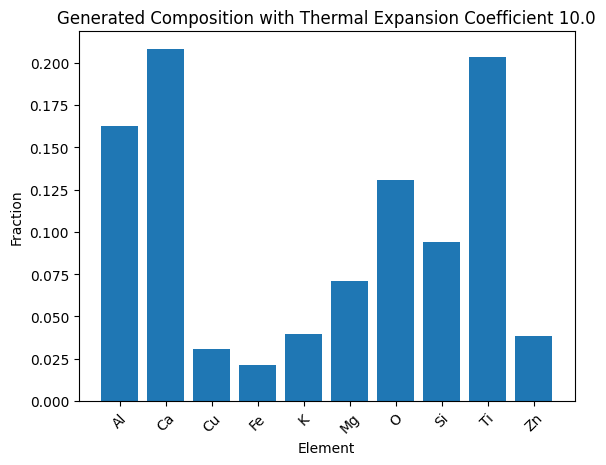

In [19]:
# Function to generate new compositions with a specific thermal expansion coefficient
def generate_with_property(target_property, decoder, latent_dim, add_noise=True):
    """
    Generates a composition with a specified thermal expansion coefficient.
    """
    latent_sample = np.random.normal(size=(1, latent_dim)).astype(np.float32) if add_noise else np.zeros((1, latent_dim))
    generated_data = decoder.predict([latent_sample, target_property])  # Decode the latent sample
    return generated_data

# Generate a new composition with a target thermal expansion coefficient
target_property = np.array([[10.0]], dtype=np.float32)  # Target thermal expansion coefficient
generated_composition = generate_with_property(target_property, decoder, latent_dim)

# Display the generated composition
print("\nGenerated Composition with Thermal Expansion Coefficient 10.0:")
print(generated_composition[0])

# Plot the generated composition
plt.bar(elements, generated_composition[0])
plt.title(f"Generated Composition with Thermal Expansion Coefficient {target_property[0][0]}")
plt.ylabel("Fraction")
plt.xlabel("Element")
plt.xticks(rotation=45)
plt.show()

This decodes the fractional elemental composition back into a composition

In [20]:
# Function to convert fractional compositions back into a chemical formula
def decode_composition(fractional_composition, elements):
    """
    Converts a vector of fractional contributions into a plausible chemical formula.
    :param fractional_composition: Array of fractional contributions for each element.
    :param elements: List of element symbols corresponding to the fractions.
    :return: A string representing the chemical formula.
    """
    # Scale fractions to the nearest whole numbers while maintaining ratios
    fractional_composition = np.array(fractional_composition)
    fractions_scaled = fractional_composition / np.min(fractional_composition[fractional_composition > 0])
    rounded_counts = np.round(fractions_scaled).astype(int)
    
    # Construct the chemical formula
    formula = ""
    for el, count in zip(elements, rounded_counts):
        if count > 0:
            formula += el + (str(count) if count > 1 else "")
    return formula

# Generate a new composition with a target thermal expansion coefficient
target_property = np.array([[10.0]], dtype=np.float32)  # Target thermal expansion coefficient
generated_composition = generate_with_property(target_property, decoder, latent_dim)

# Decode the fractional composition into a chemical formula
decoded_formula = decode_composition(generated_composition[0], elements)

# Display the generated composition
print("\nGenerated Composition with Thermal Expansion Coefficient 10.0:")
print(decoded_formula)

1/1 [==============================] - 0s 41ms/step

Generated Composition with Thermal Expansion Coefficient 10.0:
Al11Ca12Cu2FeK2Mg4O5Si6Ti12Zn2
